In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division

from collections import defaultdict
from collections import Counter
from collections import OrderedDict
from riboraptor.plotting import plot_read_length_dist
from riboraptor.plotting import plot_read_counts
from riboraptor.helpers import codon_to_anticodon
from riboraptor.coherence import identify_peaks
from riboraptor.helpers import load_pickle
from riboraptor.customutils import *
from riboraptor.statistics import KS_test, KDE
from Bio import SeqIO
from scipy.stats.mstats import ks_2samp
from scipy import stats
from scipy.signal import find_peaks_cwt
import scipy.cluster.hierarchy as hac
from scipy.stats import poisson
from scipy.signal import savgol_filter

import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid')
import os
import pickle
import math
from scipy import signal
import numpy as np
import pycwt as wavelet
from pycwt.helpers import find
import pandas as pd
from scipy.spatial import distance_matrix
import statsmodels.api as sm                                          

import pyBigWig
import pybedtools

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools

from plotly.graph_objs import Scatter, Figure, Layout, Histogram, Bar
init_notebook_mode(connected=True)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/riboraptor-0.1.0-py3.6.egg/riboraptor/plotting.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cmb-panasas2/skchoud

In [3]:
coverage_pickle_dir = '/home/cmb-06/as/skchoudh/re-ribo-analysis/SRP098789/mapped/metagene_pickled_data/CDS_offset60/'
metagene_pickle_dir = '/staging/as/skchoudh/re-ribo-analysis/SRP098789/mapped/gene_coverage_collapsed_to_metagene/'

frag_len_pickle_dir = '/home/cmb-06/as/skchoudh/re-ribo-analysis/SRP098789/mapped/fragment_length_pickle/'

In [4]:
fragment_lengths = {}
for f in os.listdir(frag_len_pickle_dir):
    print(f)
    fragment_lengths[f.split('.')[0]] = pd.Series(load_pickle(os.path.join(frag_len_pickle_dir, f)))
    

SRX2536403.pickle
SRX2536404.pickle
SRX2536405.pickle
SRX2536406.pickle
SRX2536407.pickle
SRX2536408.pickle
SRX2536409.pickle
SRX2536410.pickle
SRX2536411.pickle
SRX2536412.pickle
SRX2536413.pickle
SRX2536414.pickle
SRX2536415.pickle
SRX2536416.pickle
SRX2536417.pickle
SRX2536418.pickle
SRX2536419.pickle
SRX2536420.pickle
SRX2536421.pickle
SRX2536422.pickle
SRX2536423.pickle
SRX2536424.pickle
SRX2536425.pickle
SRX2536426.pickle
SRX2536427.pickle
SRX2536428.pickle


In [5]:
coverage = {}
for f in os.listdir(coverage_pickle_dir):
    if 'metagene_normalized.pickle' in f:
        coverage[f.split('.')[0].replace('_metagene_normalized', '')] = load_pickle(os.path.join(coverage_pickle_dir, f))
group = sorted(coverage.keys())
samples_per_row = 3


metagene_coverage_expanded = {}
for f in os.listdir(metagene_pickle_dir):
    if '_metagene.pickle' in f:
        metagene_coverage_expanded[f.split('.')[0].replace('_metagene', '')] = load_pickle(os.path.join(metagene_pickle_dir, f))


In [6]:
index = 1
fig = tools.make_subplots(rows=int(np.ceil(len(group) / samples_per_row)), cols=samples_per_row, 
                          subplot_titles=group,
                          print_grid=True)
for sample in group:    
    trace = Bar(x=fragment_lengths[sample].index.tolist(),    
                y=fragment_lengths[sample].sort_index().values.tolist(), 
                name=sample)
    fig.append_trace(trace, (index-1)//samples_per_row+1, (index-1)%samples_per_row+1)
    index += 1

#fig['layout'].update(height=900, width=1200, title="hahahah")
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]
[ (5,1) x13,y13 ]  [ (5,2) x14,y14 ]  [ (5,3) x15,y15 ]
[ (6,1) x16,y16 ]  [ (6,2) x17,y17 ]  [ (6,3) x18,y18 ]
[ (7,1) x19,y19 ]  [ (7,2) x20,y20 ]  [ (7,3) x21,y21 ]
[ (8,1) x22,y22 ]  [ (8,2) x23,y23 ]  [ (8,3) x24,y24 ]
[ (9,1) x25,y25 ]  [ (9,2) x26,y26 ]  [ (9,3) x27,y27 ]



In [7]:
index = 1
fig = tools.make_subplots(rows=int(np.ceil(len(group) / samples_per_row)), cols=samples_per_row, 
                          subplot_titles=group,
                          print_grid=True)
for sample in group:
    normalizedc = coverage[sample]
    trace = Scatter(x = normalizedc.index,
                    y = normalizedc.values.tolist(),
                    mode = 'lines',
                    name = sample)
    fig.append_trace(trace, (index-1)//samples_per_row+1, (index-1)%samples_per_row+1)
    index += 1

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]
[ (5,1) x13,y13 ]  [ (5,2) x14,y14 ]  [ (5,3) x15,y15 ]
[ (6,1) x16,y16 ]  [ (6,2) x17,y17 ]  [ (6,3) x18,y18 ]
[ (7,1) x19,y19 ]  [ (7,2) x20,y20 ]  [ (7,3) x21,y21 ]
[ (8,1) x22,y22 ]  [ (8,2) x23,y23 ]  [ (8,3) x24,y24 ]
[ (9,1) x25,y25 ]  [ (9,2) x26,y26 ]  [ (9,3) x27,y27 ]



In [8]:
"""
GSM2475997	1.5 µM PF-067446846, 10 min, rep 1
GSM2475998	1.5 µM PF-067446846, 10 min, rep 2
GSM2475999	1.5 µM PF-067446846, 10 min, rep 3
GSM2476000	0.3 µM PF-067446846, 10 min, rep 1
GSM2476001	0.3 µM PF-067446846, 10 min, rep 2
GSM2476002	0.3 µM PF-067446846, 10 min, rep 3
GSM2476003	vehicle, 10 min rep 1
GSM2476004	vehicle, 10 min rep 2
GSM2476005	vehicle, 10 min rep 3
GSM2476006	1.5 µM PF-067446846, 60 min, rep 1
GSM2476007	1.5 µM PF-067446846, 60 min, rep 2
GSM2476008	1.5 µM PF-067446846, 60 min, rep 3
GSM2476009	0.3 µM PF-067446846, 60 min, rep 1
GSM2476010	0.3 µM PF-067446846, 60 min, rep 2
GSM2476011	0.3 µM PF-067446846, 60 min, rep 3
GSM2476012	vehicle, 60 min rep 1
GSM2476013	vehicle, 60 min rep 2
GSM2476014	vehicle, 60 min rep 3
GSM2476015	1.5 µM PF-067446846, 60 min, rep 4 -riboseq
GSM2476016	Vehicle, 60 min, rep 4-ribo-seq
GSM2476017	1.5 µM PF-067446846, 60 min, rep 5 -riboseq
GSM2476018	vehicle, 60 min, rep 5-Ribo-seq
GSM2476019	PF-06446846, 60 min, rep 4 -mRNA-seq
GSM2476020	vehicle, 60 min, rep 4-mRNAseq
GSM2476021	PF-06446846, 60 min, rep 5 -mRNA-seq
GSM2476022	vehicle, 60 min, rep 5-mRNAseq
"""

samples = OrderedDict({'1.5mu': OrderedDict({'10min_1': ['GSM2475997', 'GSM2475998', 'GSM2475999' ],
                                             '60min_1': ['GSM2476006', 'GSM2476007', 'GSM2476008'],
                                             '60min_2': ['GSM2476015', 'GSM2476017']}),
                      
                       '0.3mu': OrderedDict({'10min_1': ['GSM2476000', 'GSM2476001', 'GSM2476002' ],
                                             '60min_1': ['GSM2476009', 'GSM2476010', 'GSM2476011'],
                                            }),
                       
                       'vehicle': OrderedDict({'10min_1': ['GSM2476003', 'GSM2476004', 'GSM2476005'],
                                               '60min_1': ['GSM2476012', 'GSM2476013', 'GSM2476014'],
                                               '60min_2': ['GSM2476016', 'GSM2476018']}),                       
                      })
samples_srx = OrderedDict()
metadata = pd.read_table('/home/cmb-06/as/skchoudh/re-ribo-metadata/SRP098789.tsv').set_index('experiment_alias')
for treatment, treatment_dict in samples.items():
    samples_srx[treatment] = OrderedDict()
    for time_index, gsm_list in treatment_dict.items():
        srx_list = []
        for gsm in gsm_list:
            srx_list.append(str(metadata.loc[gsm]['experiment_accession']))
        samples_srx[treatment][time_index]=srx_list

In [9]:
samples_srx

OrderedDict([('1.5mu',
              OrderedDict([('10min_1',
                            ['SRX2536403', 'SRX2536404', 'SRX2536405']),
                           ('60min_1',
                            ['SRX2536412', 'SRX2536413', 'SRX2536414']),
                           ('60min_2', ['SRX2536421', 'SRX2536423'])])),
             ('0.3mu',
              OrderedDict([('10min_1',
                            ['SRX2536406', 'SRX2536407', 'SRX2536408']),
                           ('60min_1',
                            ['SRX2536415', 'SRX2536416', 'SRX2536417'])])),
             ('vehicle',
              OrderedDict([('10min_1',
                            ['SRX2536409', 'SRX2536410', 'SRX2536411']),
                           ('60min_1',
                            ['SRX2536418', 'SRX2536419', 'SRX2536420']),
                           ('60min_2', ['SRX2536422', 'SRX2536424'])]))])

# Check metagene 1.5mu

In [10]:
index = 1
samples_15 = samples_srx['1.5mu']
group = []

for key, value in samples_15.items():
    group+=value

fig = tools.make_subplots(rows=int(np.ceil(len(group) / samples_per_row)), cols=samples_per_row, 
                          subplot_titles=group,
                          print_grid=True)
for sample in group:
    normalizedc = coverage[sample]
    trace = Scatter(x = normalizedc.index,
                    y = normalizedc.values.tolist(),
                    mode = 'lines',
                    name = sample)
    fig.append_trace(trace, (index-1)//samples_per_row+1, (index-1)%samples_per_row+1)
    index += 1

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [11]:
index = 1
samples_15 = samples_srx['0.3mu']
group = []

for key, value in samples_15.items():
    group+=value

fig = tools.make_subplots(rows=int(np.ceil(len(group) / samples_per_row)), cols=samples_per_row, 
                          subplot_titles=group,
                          print_grid=True)
for sample in group:
    normalizedc = coverage[sample]
    trace = Scatter(x = normalizedc.index,
                    y = normalizedc.values.tolist(),
                    mode = 'lines',
                    name = sample)
    fig.append_trace(trace, (index-1)//samples_per_row+1, (index-1)%samples_per_row+1)
    index += 1

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [12]:
index = 1
samples_15 = samples_srx['vehicle']
group = []

for key, value in samples_15.items():
    group+=value

fig = tools.make_subplots(rows=int(np.ceil(len(group) / samples_per_row)), cols=samples_per_row, 
                          subplot_titles=group,
                          print_grid=True)
for sample in group:
    normalizedc = coverage[sample]
    trace = Scatter(x = normalizedc.index,
                    y = normalizedc.values.tolist(),
                    mode = 'lines',
                    name = sample)
    fig.append_trace(trace, (index-1)//samples_per_row+1, (index-1)%samples_per_row+1)
    index += 1

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [13]:
metagene_offsets = {}
for sample in coverage.keys():
    peak = identify_peaks(coverage[sample])
    metagene_offsets[sample] = peak
    

In [14]:
codon_map = pd.read_csv('/home/cmb-panasas2/skchoudh/genomes/hg38/cds_fasta/codon_lookup_table.tsv').rename(columns={'Unnamed: 0': 'gene_name'}).set_index('gene_name')


In [15]:
from scipy.signal import savgol_filter

def get_shifted_gene_profile(gene_profile, gene_offset_5p, metagene_offset, atg_location):
    # How many upstream 5'UTr basese were counted?    
    assert gene_offset_5p >= 0    
    # Say -12 is the metagene offset
    assert metagene_offset <= 0
    total_length = len(gene_profile)
    gene_profile = pd.Series(gene_profile, index=np.arange(-gene_offset_5p, len(gene_profile)-gene_offset_5p))
    
    # Shoft -12 to zero by adding the - of metagene_offset
    gene_profile = gene_profile.rename(lambda x: x-metagene_offset)
    
    # For genes whivh are on negatve strand because of 1-offset
    # we end up counting one extra base.
    # So ATG does not start at 0-1-2
    # but at 1-2-3
    # So we need to again do offset
    assert atg_location in [0, 1, 2]
    shifted_gene_profile = gene_profile.rename(lambda x: x-atg_location)
    return shifted_gene_profile

def avg_profiles(samples, gene_name):
    samplewise_profiles = []
    for sample in samples:
        print(sample)
        gene_coverage_tsv = '/home/cmb-06/as/skchoudh/re-ribo-analysis/SRP098789/mapped/gene_coverages/{}_gene_coverages.tsv.gz'.format(sample)
        gene_coverage = pd.read_table(gene_coverage_tsv, compression='gzip').set_index('gene_name').loc[gene_name]
        gene_counts = eval(gene_coverage['count'])
        #gene_mean = eval(gene_coverage['mean'])
        metagene_offset = metagene_offsets[sample]
        atg_location = codon_map.loc[gene_name]['ATG_first_location']
        fasta_length = codon_map.loc[gene_name]['fasta_length'] - atg_location
        gene_offset_5p = gene_coverage['offset_5p']
        gene_profile = get_shifted_gene_profile(gene_counts, gene_offset_5p, metagene_offset, atg_location)
        gene_profile = gene_profile#.get(np.arange(0, fasta_length))
        gene_profile_normalized = gene_profile/gene_profile.mean(skipna=True)
        samplewise_profiles.append(gene_profile_normalized)
    samplewise_profiles = np.array(samplewise_profiles)
    return np.nanmean(samplewise_profiles, axis=0)

def sum_profiles(samples, gene_name):
    samplewise_profiles = []
    for sample in samples:
        print(sample)
        gene_coverage_tsv = '/home/cmb-06/as/skchoudh/re-ribo-analysis/SRP098789/mapped/gene_coverages/{}_gene_coverages.tsv.gz'.format(sample)
        gene_coverage = pd.read_table(gene_coverage_tsv, compression='gzip').set_index('gene_name').loc[gene_name]
        gene_counts = eval(gene_coverage['count'])
        #gene_mean = eval(gene_coverage['mean'])
        metagene_offset = metagene_offsets[sample]
        atg_location = codon_map.loc[gene_name]['ATG_first_location']
        fasta_length = codon_map.loc[gene_name]['fasta_length'] - atg_location
        gene_offset_5p = gene_coverage['offset_5p']
        gene_profile = get_shifted_gene_profile(gene_counts, gene_offset_5p, metagene_offset, atg_location)
        samplewise_profiles.append(gene_profile)
    samplewise_profiles = np.array(samplewise_profiles)
    return np.nansum(samplewise_profiles, axis=0)

def collpase_gene_coverage_to_codon(gene_profile):
    """Assume the gene 0 is the true zero and exclude 
    trailing positions which are not 0 mod 3
    """
    codon_profile = []
    for i in range(0, len(gene_profile)-3, 3):
        codon_profile.append(np.nansum(gene_profile[np.arange(i, i+3)]))
    return pd.Series(codon_profile, index=np.arange(1, len(codon_profile)+1))
        
def g_transform(data):
    data = np.array(data)
    return np.log(np.log(data+1)+1)

def inverse_g_transform(y):
    y = np.array(y)
    return np.exp(np.exp(y)-1)-1


def baseline_correct(y, n_iterations=100):
    z = g_transform(y)
    z_copy = np.empty(len(z))
    n = len(z)
    for i in range(0, n_iterations):
        for j in range(i, n-i):
            mean_z = 0.5*(z[j-i]+[j+i])
            mean_z = min(mean_z, z[j])
            z_copy[j] = mean_z
        for k in range(i, n-i):
            z[k] = z_copy[k]
    inv_z = inverse_g_transform(z)
    return inv_z



def med_abs_dev(data):
    """Calculate Median absolute deviation
    """
    return 1.4826*max(np.nanmedian(np.abs(data-np.nanmedian(data))), 1e-4)

def calculate_peaks(data, order=3, snr=2.5):
    """ Calculate Peaks
    """
    if isinstance(data, pd.Series):
        index = data.index
    else:
        index = np.arange(0, len(data))
    data = np.array(data)
    data_rel_max_idx = signal.argrelmax(data, axis=0, order=order)[0]
    noise = med_abs_dev(data)
    #peaks_height = np.zeros(len(data))
    peaks_idx = [x for x in data_rel_max_idx if data[x] > snr*noise]
    peaks_x = index[peaks_idx]
    #for x in peaks_idx:
    #    peaks_height[x] = data[x]
    peaks_height = data[peaks_idx]
    return peaks_x, peaks_height

def calculate_snr(data):
    data = np.array(data)
    sigma = med_abs_dev(data)
    return data/sigma

def baseline_correct(y, n_iterations=100):
    z = g_transform(y)
    z_copy = np.empty(len(z))
    n = len(z)
    for i in np.arange(n_iterations, 0, -1):
        for j in np.arange(i, n-i):
            mean_z = 0.5*(z[j-i]+z[j+i])
            mean_z = min(mean_z, z[j])
            z_copy[j] = mean_z
        for k in np.arange(i, n-i):
            z[k] = z_copy[k]
    inv_z = inverse_g_transform(z)
    return inv_z

def remove_baseline(y, baseline):
    return y-baseline    

def Z_score(data):
    return (data-np.nanmean(data))/np.std(data)

def get_poisson_lambda(data, method='ncg'):
    res = sm.Poisson(data, np.ones_like(data)).fit(                                                              
        disp=0, method=method)                               
    l = res.predict()[0]  
    return l

def get_blockwise_poisson_lambdas(data, blocksize=3, method='ncg'):
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    lambdas = []          
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        block_coverage = data[start:end]      
        lambdas.append(get_poisson_lambda(block_coverage, method))
        index+=1
    return lambdas

def load_gene_fasta(gene_name):
    fasta_f = '/home/cmb-panasas2/skchoudh/genomes/hg38/cds_fasta/cds_gene_{}.fasta'.format(gene_name)
    fasta = SeqIO.parse(open(fasta_f), 'fasta')
    for record in fasta:
        return str(record.seq)

def mark_extreme_points_poisson(data, lambdas, blocksize):
    data = list(data)
    pvalues = []
    """
    for i in range(0, len(lambdas)):
        for point in data[i:i+blocksize]:
            pvalue = poisson.sf(point, lambdas[i])#1-poisson.cdf(point, lambdas[i])
            pvalues.append(pvalue)
    """
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        for point in data[start:end]:
            pvalue = poisson.sf(point, lambdas[index])#1-poisson.cdf(point, lambdas[i])
            pvalues.append(pvalue)
        index+=1
    return pvalues
            
def get_position_wise_cdf(values):
    values = list(values)
    total = np.nansum(values)
    cdf = np.cumsum(values)/total
    return cdf

def get_poisson_difference(data, lambdas, blocksize):
    data = list(data)
    differences = []
    j = 0
    """
    for i in range(0, len(data)):
        difference = data[i] - lambdas[i//blocksize]
        differences.append(difference)
    
    for i in range(0, len(lambdas)):
        for point in data[i:i+blocksize]:
            difference = point - lambdas[i]
            differences.append(difference)
    """
    data = list(data)
    pointer = 0                                                   
    index = 0                                                     
    gene_length = len(data)
    while pointer != gene_length:                          
        if (index + 1) * blocksize >= gene_length - 1:     
            end = gene_length - 1                          
            pointer = gene_length                          
        else:                                                     
            end = (index + 1) * blocksize                         
        start = index * blocksize                                 
        for point in data[start:end]:
            difference = point - lambdas[index]
            differences.append(difference)
        index+=1
    
    return differences

def expand_poisson_lambda(lambdas, blocksize=3):
    lambdas = list(lambdas)
    expanded = []
    for i in range(0, len(lambdas)):
        lambda_points = [lambdas[i]]*blocksize
        expanded += lambda_points
    return expanded

def gaussian_pvalue(values):
    values = np.array(values)
    mean = np.nanmean(values)
    std = np.std(values)
    zscore = (values - mean)/std
    pvalues = stats.norm.sf(zscore)
    return pvalues

# 10 min avg

In [18]:
def export_gene_coverage(gene_name, sample, filename):
    gene_coverage_tsv = '/home/cmb-06/as/skchoudh/re-ribo-analysis/SRP098789/mapped/gene_coverages/{}_gene_coverages.tsv.gz'.format(sample)
    gene_coverage = pd.read_table(gene_coverage_tsv, compression='gzip').set_index('gene_name').loc[gene_name]
    gene_counts = eval(gene_coverage['count'])
        #gene_mean = eval(gene_coverage['mean'])
    metagene_offset = metagene_offsets[sample]
    atg_location = codon_map.loc[gene_name]['ATG_first_location']
    fasta_length = codon_map.loc[gene_name]['fasta_length'] - atg_location
    gene_offset_5p = gene_coverage['offset_5p']
    gene_profile = get_shifted_gene_profile(gene_counts, gene_offset_5p, metagene_offset, atg_location)
    gene_profile = gene_profile#.get(np.arange(0, fasta_length))
    gene_profile_normalized = np.array(gene_profile/gene_profile.mean(skipna=True))
    np.savetxt('../data/{}.txt'.format(filename), gene_profile_normalized)

    

In [22]:
gene_name = 'ENSG00000169174'

mu15_10min = samples_srx['1.5mu']['10min_1']
for index, sample in enumerate(mu15_10min):
    export_gene_coverage(gene_name, sample, 'PCSK9_15mu_10min_replicate_{}'.format(index))

In [23]:
gene_name = 'ENSG00000169174'
mu15_60min = samples_srx['1.5mu']['60min_1']
for index, sample in enumerate(mu15_60min):
    export_gene_coverage(gene_name, sample, 'PCSK9_15mu_60min_replicate_{}'.format(index))

In [24]:
gene_name = 'ENSG00000169174'
mu15_60min = samples_srx['0.3mu']['10min_1']
for index, sample in enumerate(mu15_60min):
    export_gene_coverage(gene_name, sample, 'PCSK9_3mu_10min_replicate_{}'.format(index))

In [25]:
gene_name = 'ENSG00000169174'
mu15_60min = samples_srx['0.3mu']['60min_1']
for index, sample in enumerate(mu15_60min):
    export_gene_coverage(gene_name, sample, 'PCSK9_3mu_60min_replicate_{}'.format(index))

SRX2536403
SRX2536404
SRX2536405


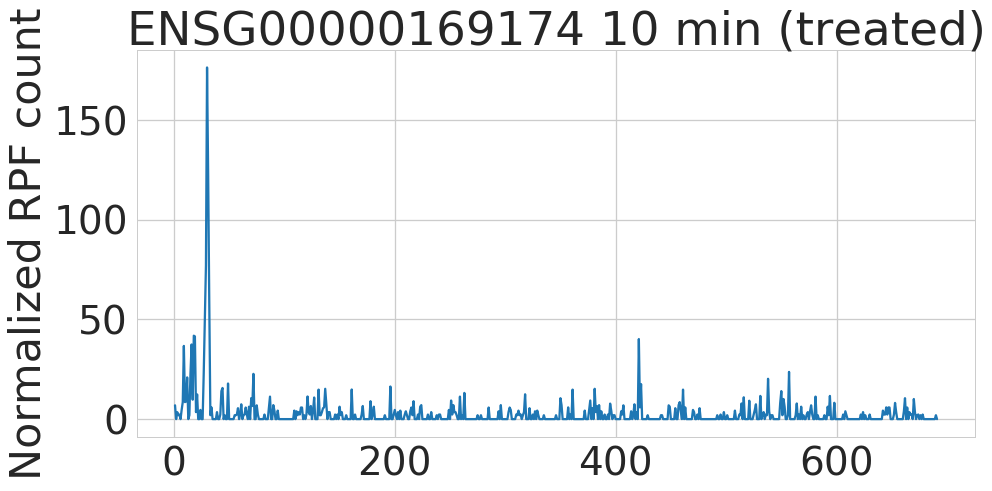

In [365]:
gene_name = 'ENSG00000169174'
mu15_10min = samples_srx['1.5mu']['10min_1']
mu15_10min_avg = avg_profiles(mu15_10min, gene_name)

sns.set_context('talk', font_scale=3)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(collpase_gene_coverage_to_codon(mu15_10min_avg))
ax.set_title(gene_name+' 10 min (treated)')
ax.set_ylabel('Normalized RPF count')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_avg_gene_profile.png', dpi=200)

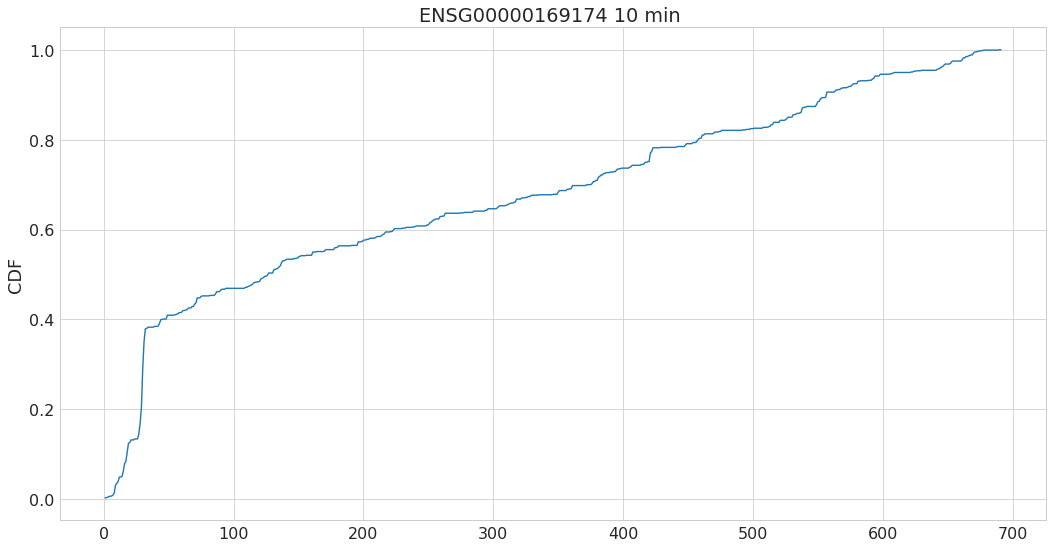

In [214]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(gene_name+' 10 min (treated)')
ax.plot(get_position_wise_cdf(collpase_gene_coverage_to_codon(mu15_10min_avg)))
ax.set_ylabel('CDF')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_avg_gene_profile_cdf.png', dpi=200)

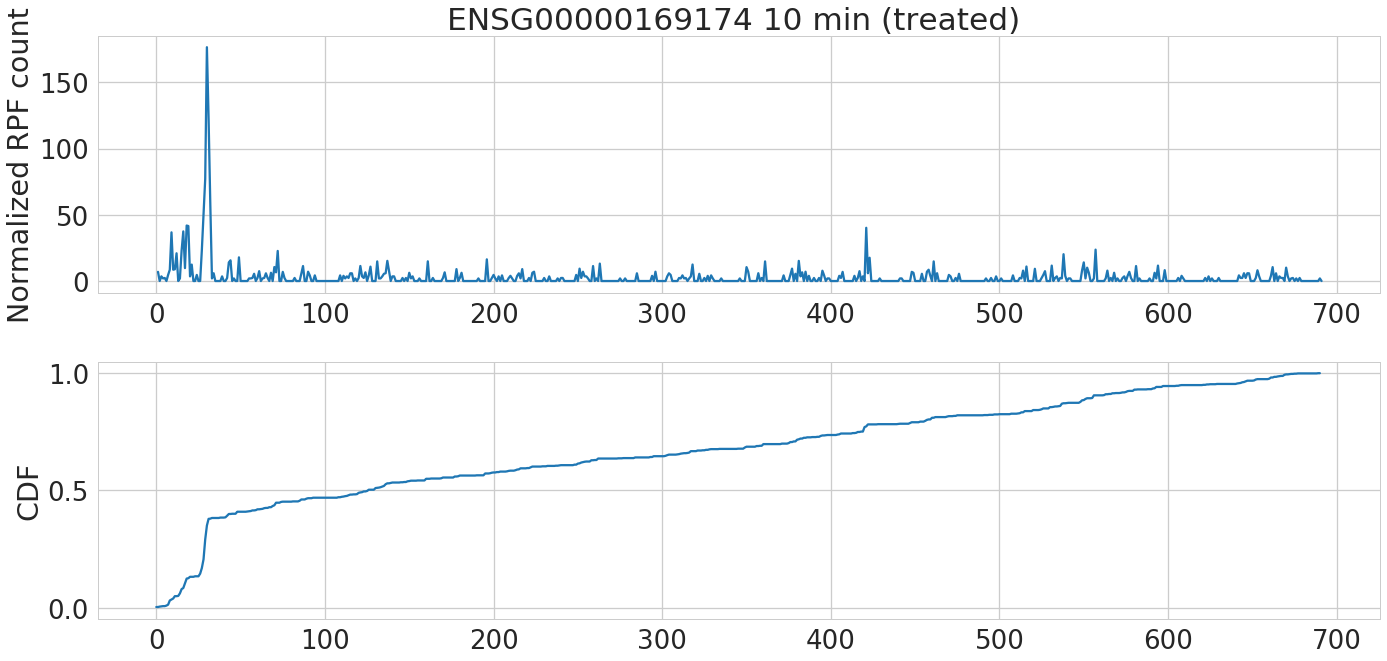

In [364]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(211)
ax1.plot(collpase_gene_coverage_to_codon(mu15_10min_avg))
ax1.set_title(gene_name+' 10 min (treated) ')
ax1.set_ylabel('Normalized RPF count')
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(get_position_wise_cdf(collpase_gene_coverage_to_codon(mu15_10min_avg)))
ax2.set_ylabel('CDF')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_avg_gene_profile_cdf_combined.png', dpi=200)

# Poisson fit!

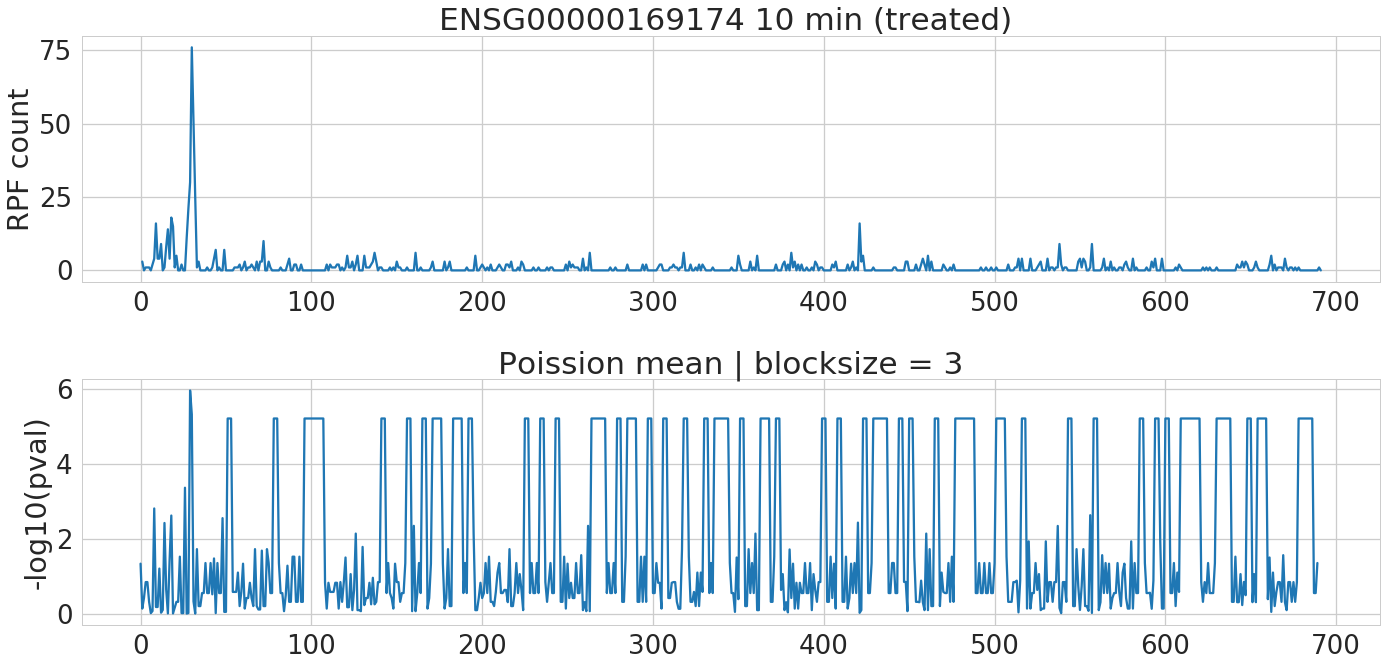

In [362]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(211)
ax1.plot(collpase_gene_coverage_to_codon(mu15_10min_sum))
ax1.set_title(gene_name+' 10 min (treated) ')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(collpase_gene_coverage_to_codon(mu15_10min_sum), blocksize=3)
pvalues = mark_extreme_points_poisson(collpase_gene_coverage_to_codon(mu15_10min_sum), lambdas, blocksize=3)
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(-np.log10(pvalues))
ax2.set_ylabel('-log10(pval)')
ax2.set_title('Poission mean | blocksize = 3')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_poisson_blocksize3_twopanel.png', dpi=200)

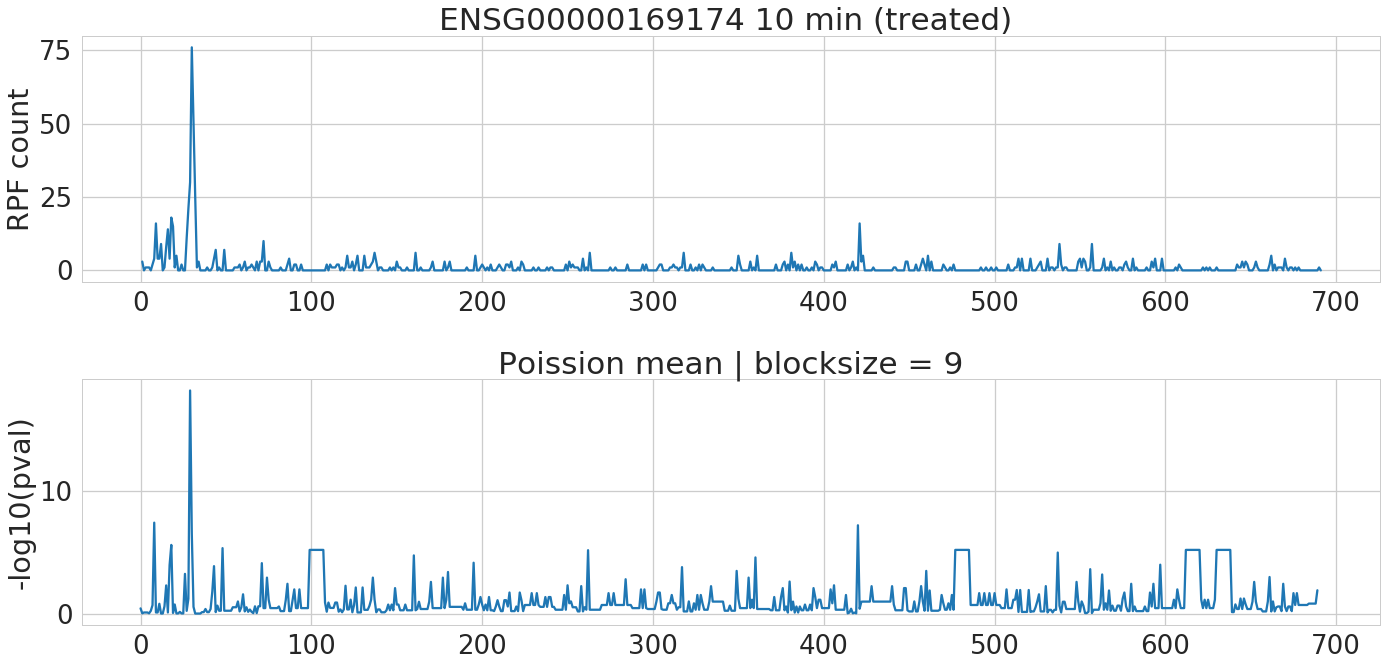

In [363]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(211)
ax1.plot(collpase_gene_coverage_to_codon(mu15_10min_sum))
ax1.set_title(gene_name+' 10 min (treated) ')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(collpase_gene_coverage_to_codon(mu15_10min_sum), blocksize=9)
pvalues = mark_extreme_points_poisson(collpase_gene_coverage_to_codon(mu15_10min_sum), lambdas, blocksize=9)
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(-np.log10(pvalues))
ax2.set_ylabel('-log10(pval)')
ax2.set_title('Poission mean | blocksize = 9')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_poisson_blocksize09_twopanel.png', dpi=200)

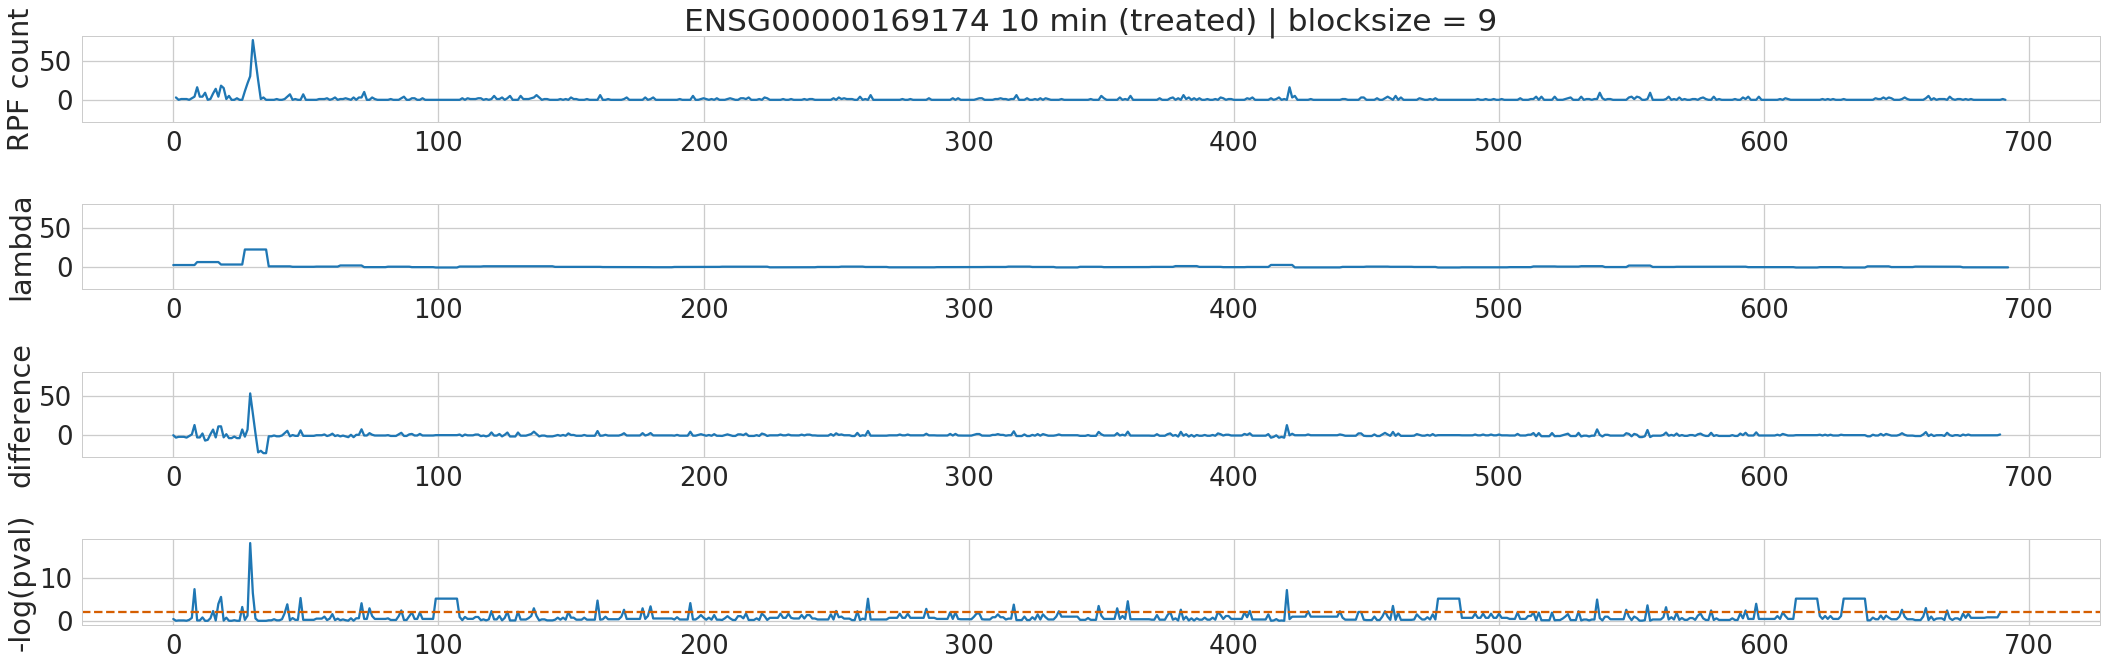

In [355]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (treated) | blocksize = 9')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(data, blocksize=9)
pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=9)

ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
#ax2.plot(get_poisson_difference(data, lambdas, 9))
ax2.plot(expand_poisson_lambda(lambdas, blocksize=9))
ax2.set_ylabel('lambda')

ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
#ax3.plot(-np.log10(pvalues))
ax3.plot(get_poisson_difference(data, lambdas, 9))
ax3.set_ylabel('difference')
#ax3.set_title('Poission mean | blocksize = 9')

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(-np.log10(pvalues))
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
ax4.set_ylabel('-log(pval)')
#ax4.set_title('Poission mean | blocksize = 9')

fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_poisson_blocksize09.png', dpi=200)

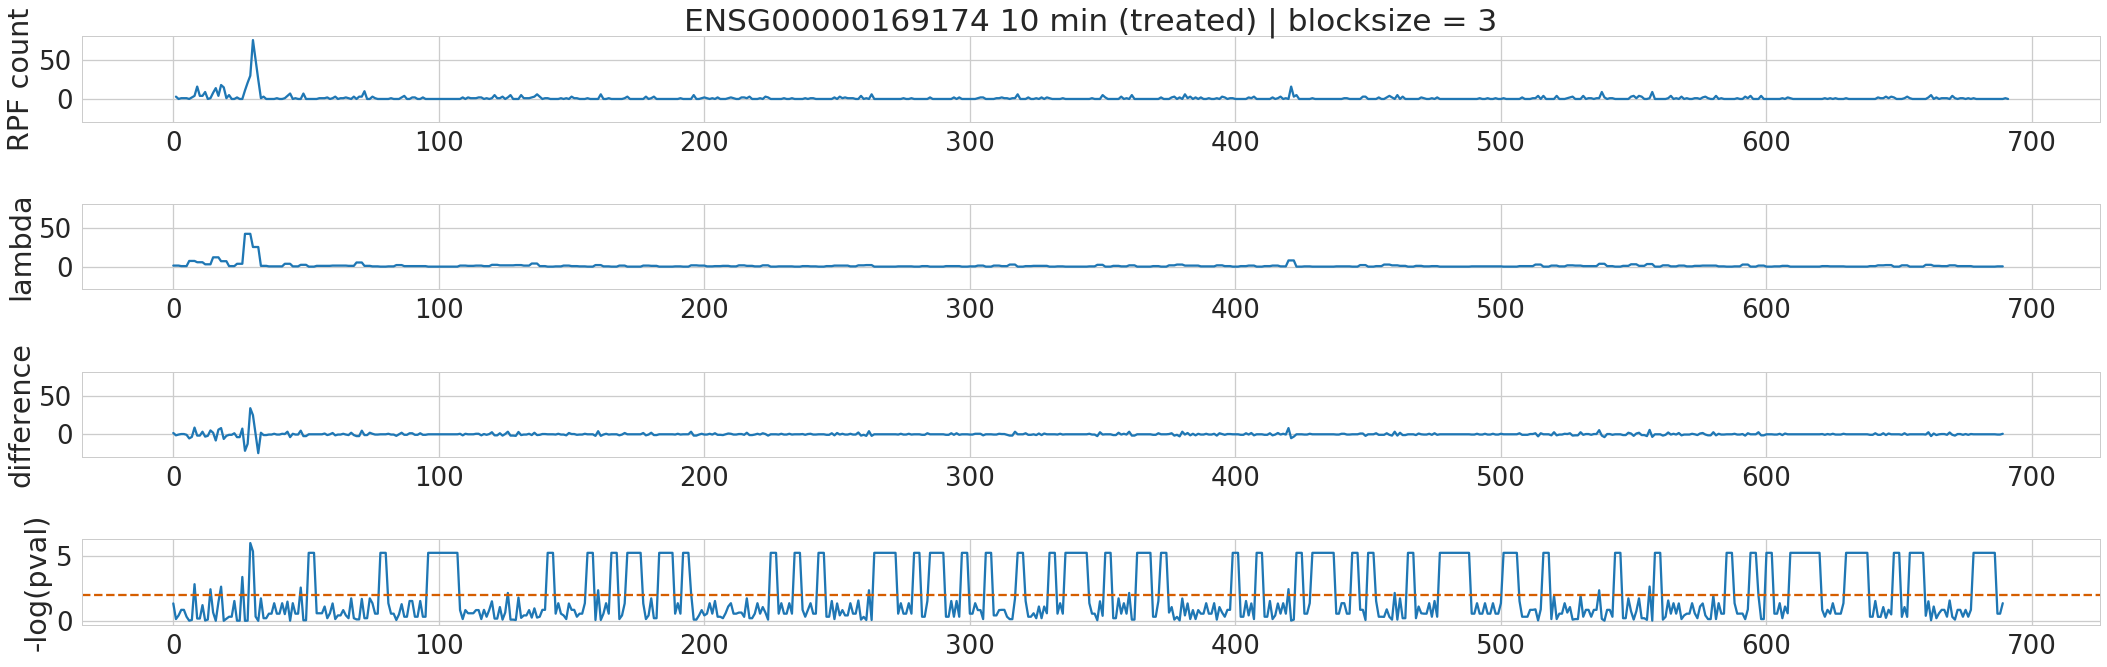

In [356]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (treated) | blocksize = 3')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(data, blocksize=3)
pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=3)

ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot(expand_poisson_lambda(lambdas, blocksize=3))
ax2.set_ylabel('lambda')

ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
ax3.plot(get_poisson_difference(data, lambdas, 3))
ax3.set_ylabel('difference')


ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(-np.log10(pvalues))
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
ax4.set_ylabel('-log(pval)')
#ax4.set_title('Poission mean | blocksize = 9')

fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_poisson_blocksize03.png', dpi=200)

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



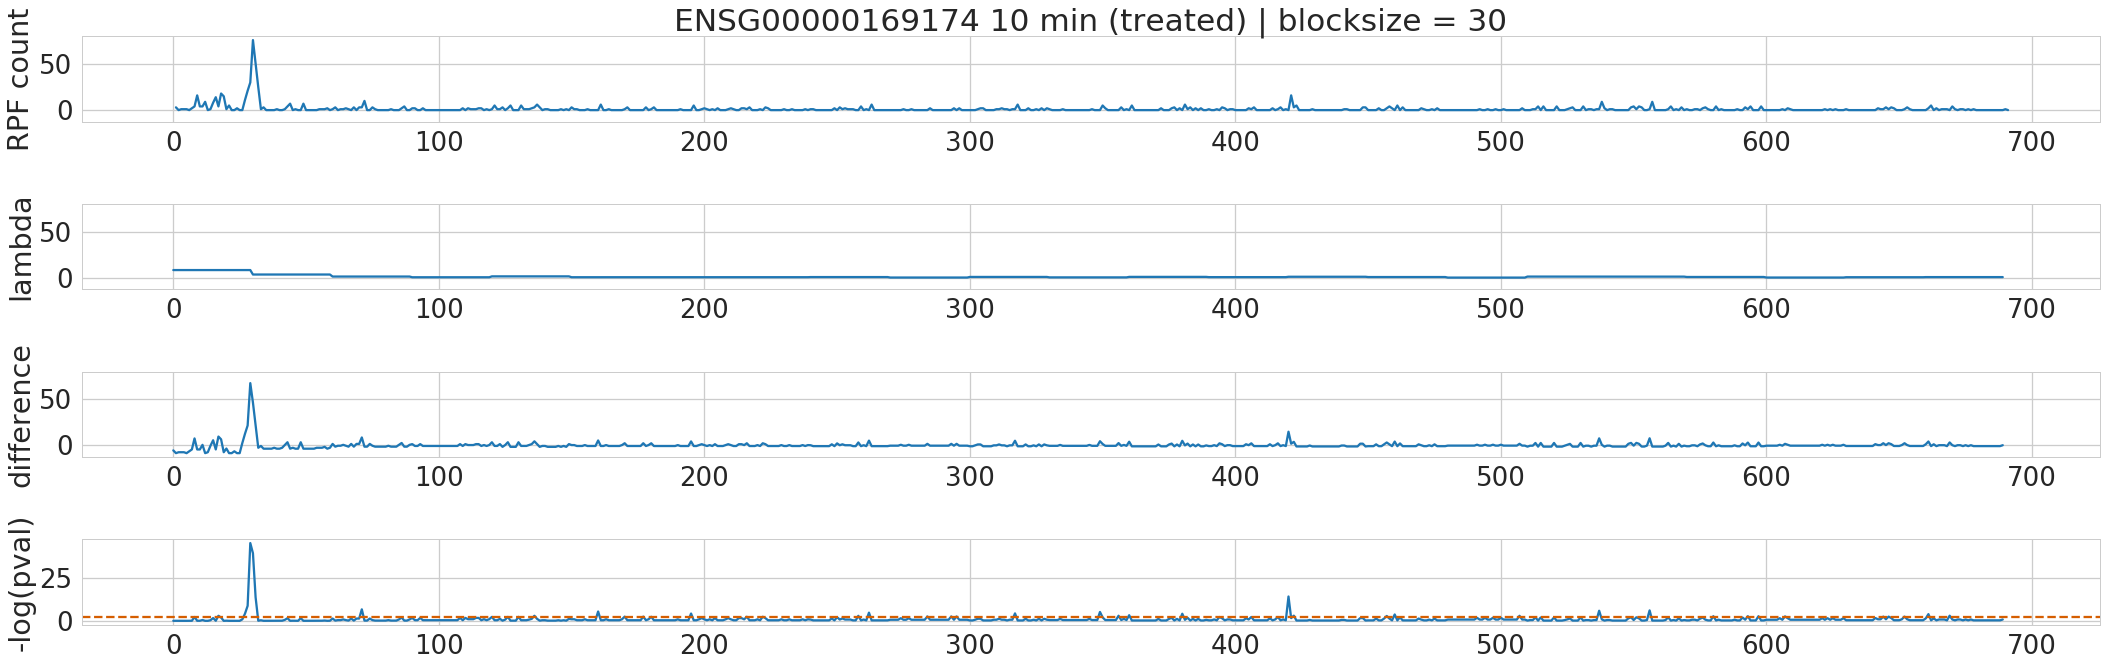

In [357]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (treated) | blocksize = 30')
ax1.set_ylabel('RPF count')

lambdas = get_blockwise_poisson_lambdas(data, blocksize=30)
pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=30)

ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot(expand_poisson_lambda(lambdas, blocksize=30))
ax2.set_ylabel('lambda')

ax3 = plt.subplot(413, sharex=ax1, sharey=ax1)
ax3.plot(get_poisson_difference(data, lambdas, 30))
ax3.set_ylabel('difference')


ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(-np.log10(pvalues))
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
ax4.set_ylabel('-log(pval)')
#ax4.set_title('Poission mean | blocksize = 9')

fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_poisson_blocksize30.png', dpi=200)

In [367]:
from Bio import SeqIO
fasta = SeqIO.parse(open('/home/cmb-panasas2/skchoudh/genomes/hg38/cds_fasta/cds_gene_ENSG00000169174.fasta'), 'fasta')
for record in fasta:
    fasta = str(record.seq)


In [369]:
fasta[29*3:29*3+3]

'GCG'

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



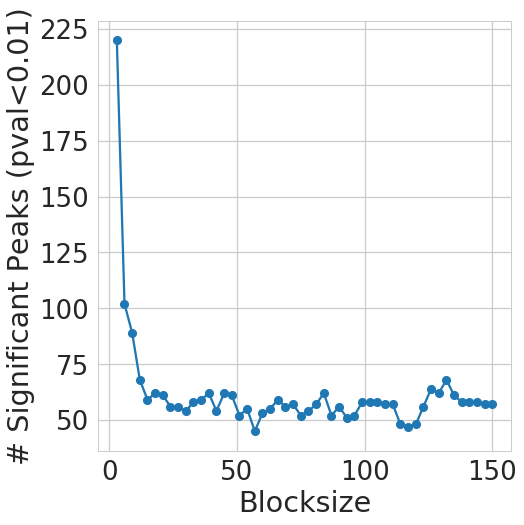

In [372]:
sns.set_context('talk', font_scale=2)
significant_peaks_lambdawise = []
blocksizes = []
for i in range(3, 151, 3):
    lambdas = get_blockwise_poisson_lambdas(data, blocksize=i)
    pvalues = mark_extreme_points_poisson(data, lambdas, blocksize=i)
    pvalues = -np.log10(pvalues)
    filtered_pvals = list(filter(lambda x: x>=2, pvalues))
    blocksizes.append(i)
    significant_peaks_lambdawise.append(len(filtered_pvals))
fig, ax  = plt.subplots(figsize=(8, 8))
ax.plot(blocksizes,  significant_peaks_lambdawise, marker='o')
ax.set_ylabel('# Significant Peaks (pval<0.01)')
ax.set_xlabel('Blocksize')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_blocksizes_vs_peaks_poisson.png', dpi=200)

# 60 min avg

SRX2536412
SRX2536413
SRX2536414


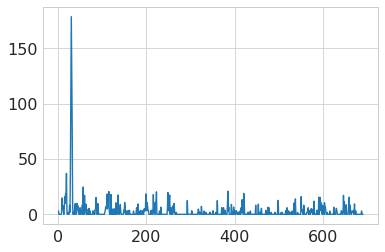

In [169]:
gene_name = 'ENSG00000169174'
mu15_60min = samples_srx['1.5mu']['60min_1']
mu15_60min_avg = avg_profiles(mu15_60min, gene_name)
plt.plot(collpase_gene_coverage_to_codon(mu15_60min_avg))

SRX2536403
SRX2536404
SRX2536405


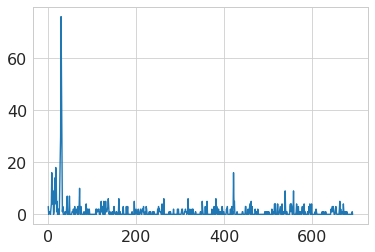

In [170]:
mu15_10min_sum = sum_profiles(mu15_10min, gene_name)
plt.plot(collpase_gene_coverage_to_codon(mu15_10min_sum))

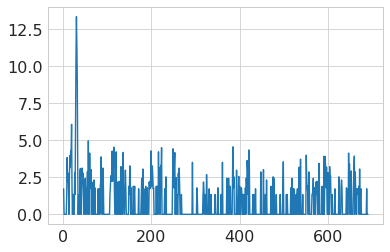

In [115]:
plt.plot(np.sqrt(collpase_gene_coverage_to_codon(mu15_10min_avg)))

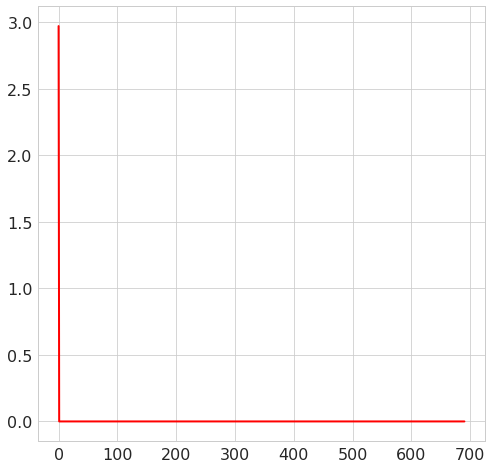

In [119]:
fig, ax  = plt.subplots(figsize=(8,8))


baseline = baseline_correct(collpase_gene_coverage_to_codon(mu15_10min_avg))
ax.plot(baseline, color='red', linewidth=2)

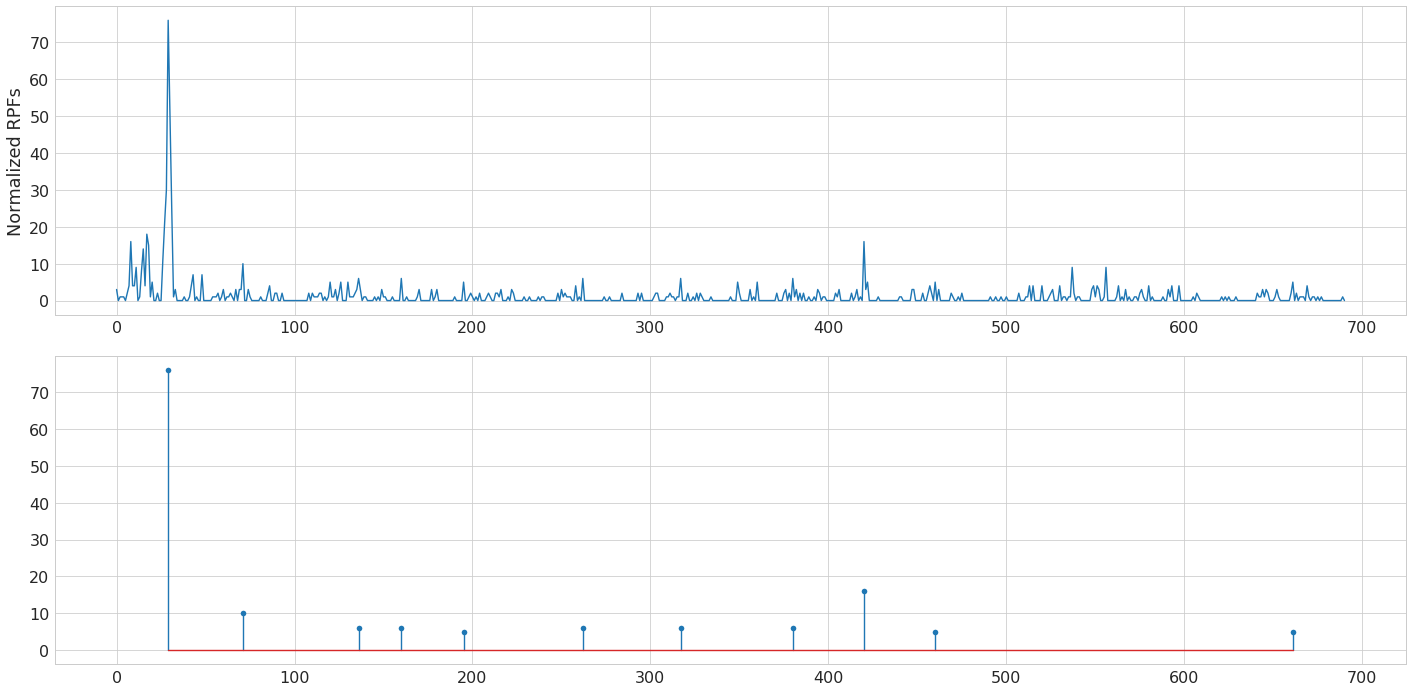

In [213]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(211)
ax1.plot(data)
ax1.set_ylabel('Normalized RPFs')
ax2 = plt.subplot(212, sharex=ax1)
peaks_x, peaks_height = calculate_peaks(data, snr=1)
ax2.stem(peaks_x, peaks_height)
fig.suptitle('')
fig.tight_layout()

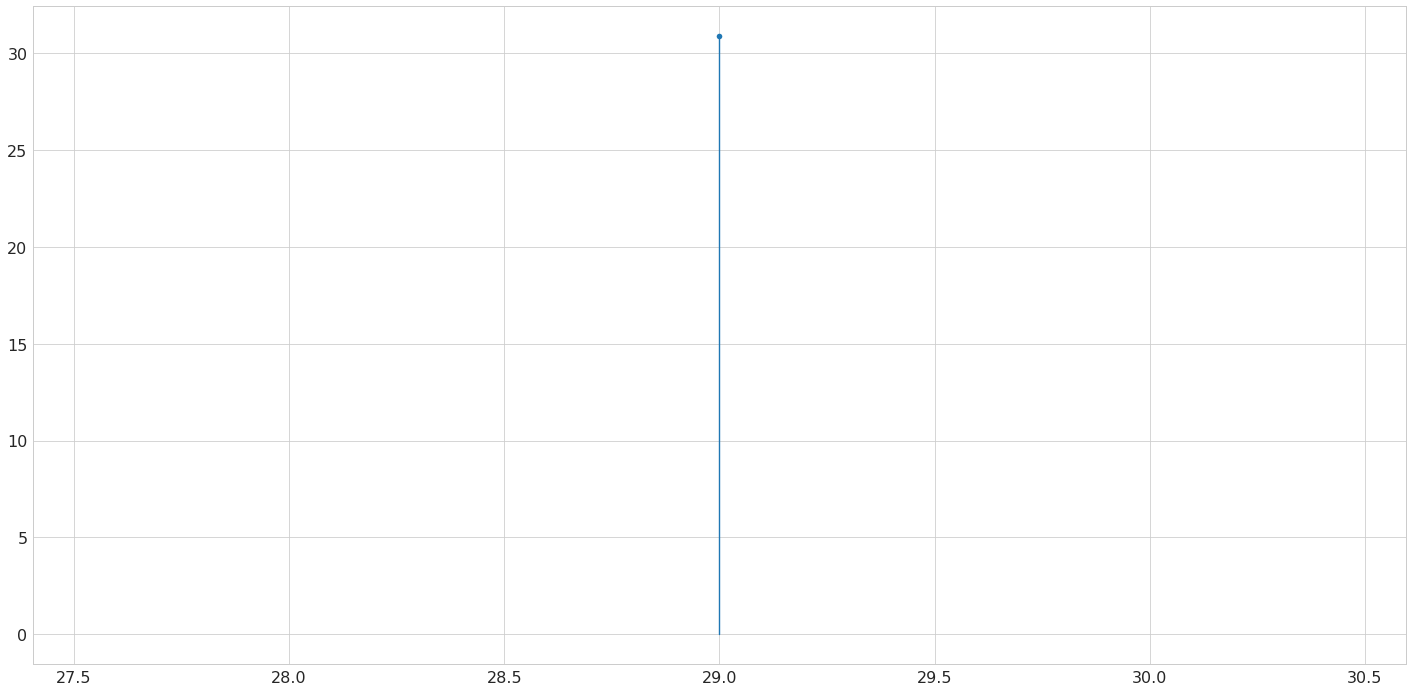

In [210]:
fig, ax = plt.subplots(figsize=(20,10))
peaks_x, peaks_height = calculate_peaks(savgol_filter(data, 15, 2))
ax.stem(peaks_x, peaks_height)
fig.tight_layout()

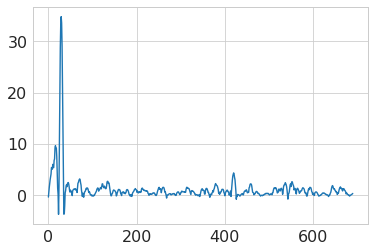

In [203]:
plt.plot(savgol_filter(data, 13, 2))

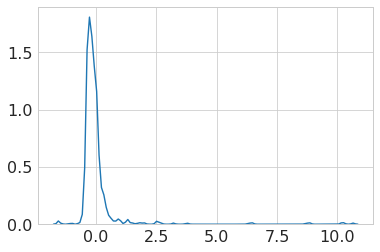

In [204]:
sns.kdeplot(Z_score(savgol_filter(data, 13, 2)))

In [186]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

(-1.5, 1.5)

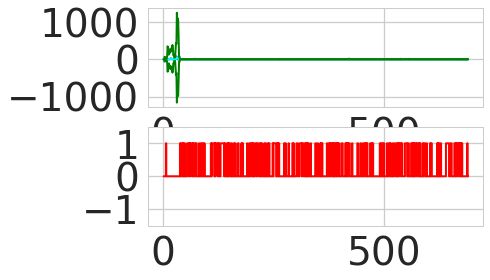

In [193]:
y = data

# Settings: lag = 30, threshold = 5, influence = 0
lag = 3
threshold = 50
influence = 0

# Run algo with settings from above
result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)

# Plot enrichment over adjancet positions! 

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning:

divide by zero encountered in log

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning:

divide by zero encountered in log

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning:

invalid value encountered in double_scalars

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/clipseq/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning:

divide by zero encountered in log



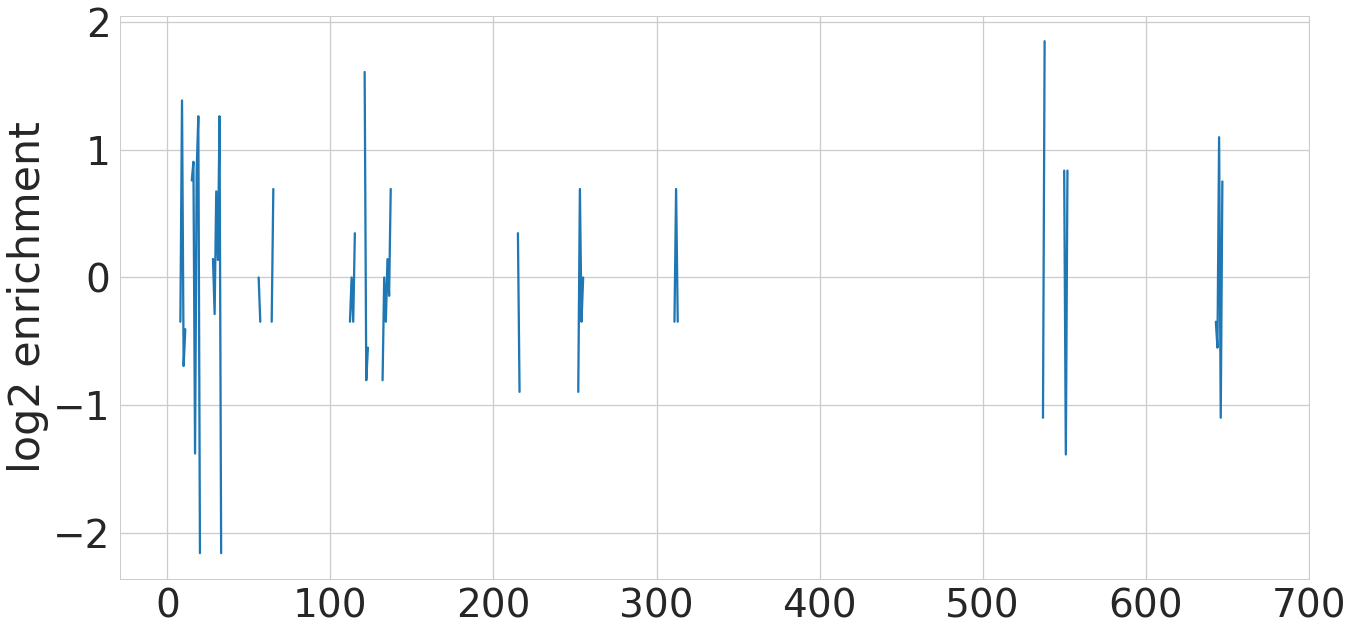

In [185]:
data = list(collpase_gene_coverage_to_codon(mu15_10min_sum))
data_adjacent_enriched = []
for i in range(0, len(data)):
    if i == 0:
        enrichment = np.log(data[i])-np.log(data[i+1])
    elif i==len(data)-1:
        enrichment = np.log(data[i])-np.log(data[i-1])
    else:
        enrichment = np.log(data[i])-np.log(np.sqrt(data[i-1]))-np.log(np.sqrt(data[i+1]))
    data_adjacent_enriched.append(enrichment)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(list(range(1, len(data_adjacent_enriched)+1)), data_adjacent_enriched)
ax.set_ylabel('log2 enrichment')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_naive_log2_enrichment.png', dpi=200)

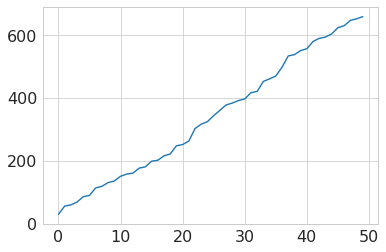

In [164]:
plt.plot( find_peaks_cwt(data, [5]))

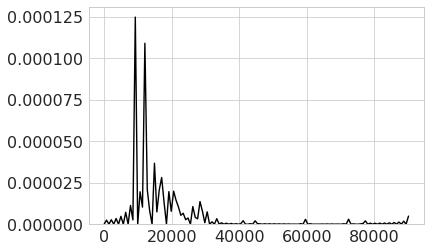

In [117]:
#snr = calculate_snr(collpase_gene_coverage_to_codon(mu15_10min_avg))
snr = calculate_snr(np.sqrt(collpase_gene_coverage_to_codon(mu15_10min_avg)))
sns.kdeplot(snr, color='black',bw=.25)

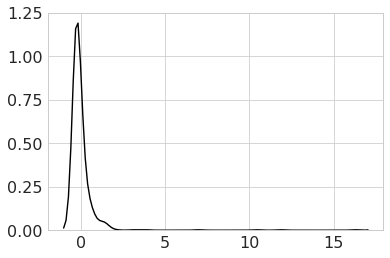

In [121]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min')
ax1.set_ylabel('RPF count')

ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot()
ax2.set_ylabel('lambda')

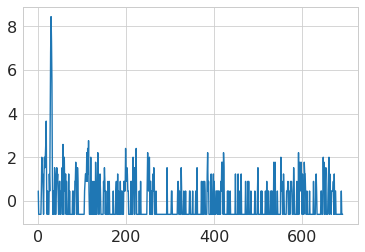

In [166]:
plt.plot(Z_score(np.sqrt(collpase_gene_coverage_to_codon(mu15_10min_sum))))

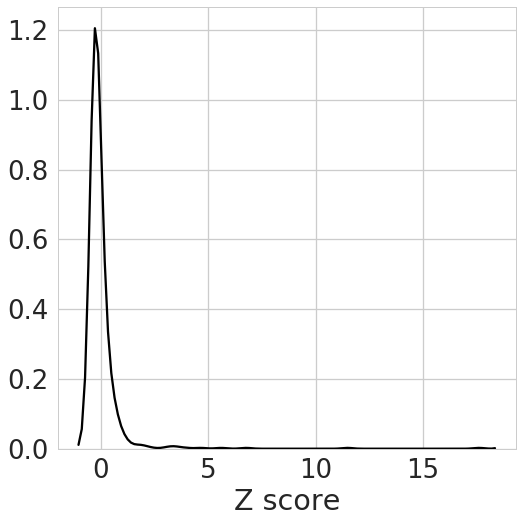

In [374]:
fig, ax = plt.subplots(figsize=(8,8))

sns.kdeplot(Z_score(collpase_gene_coverage_to_codon(mu15_10min_sum)), color='black',  bw=.25, ax=ax)
ax.set_label('Density')
ax.set_xlabel('Z score')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_zscore.png')

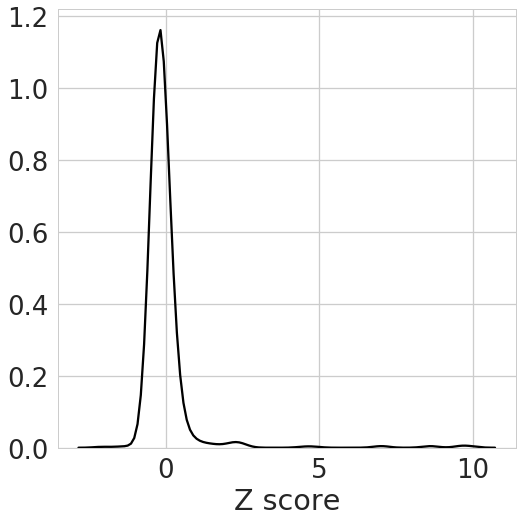

In [373]:
fig, ax = plt.subplots(figsize=(8,8))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

sns.kdeplot(Z_score(savgol_filter(data, 15, 3)), color='black',  bw=.25, ax=ax)
ax.set_label('Density')
ax.set_xlabel('Z score')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_zscore_savgol.png')

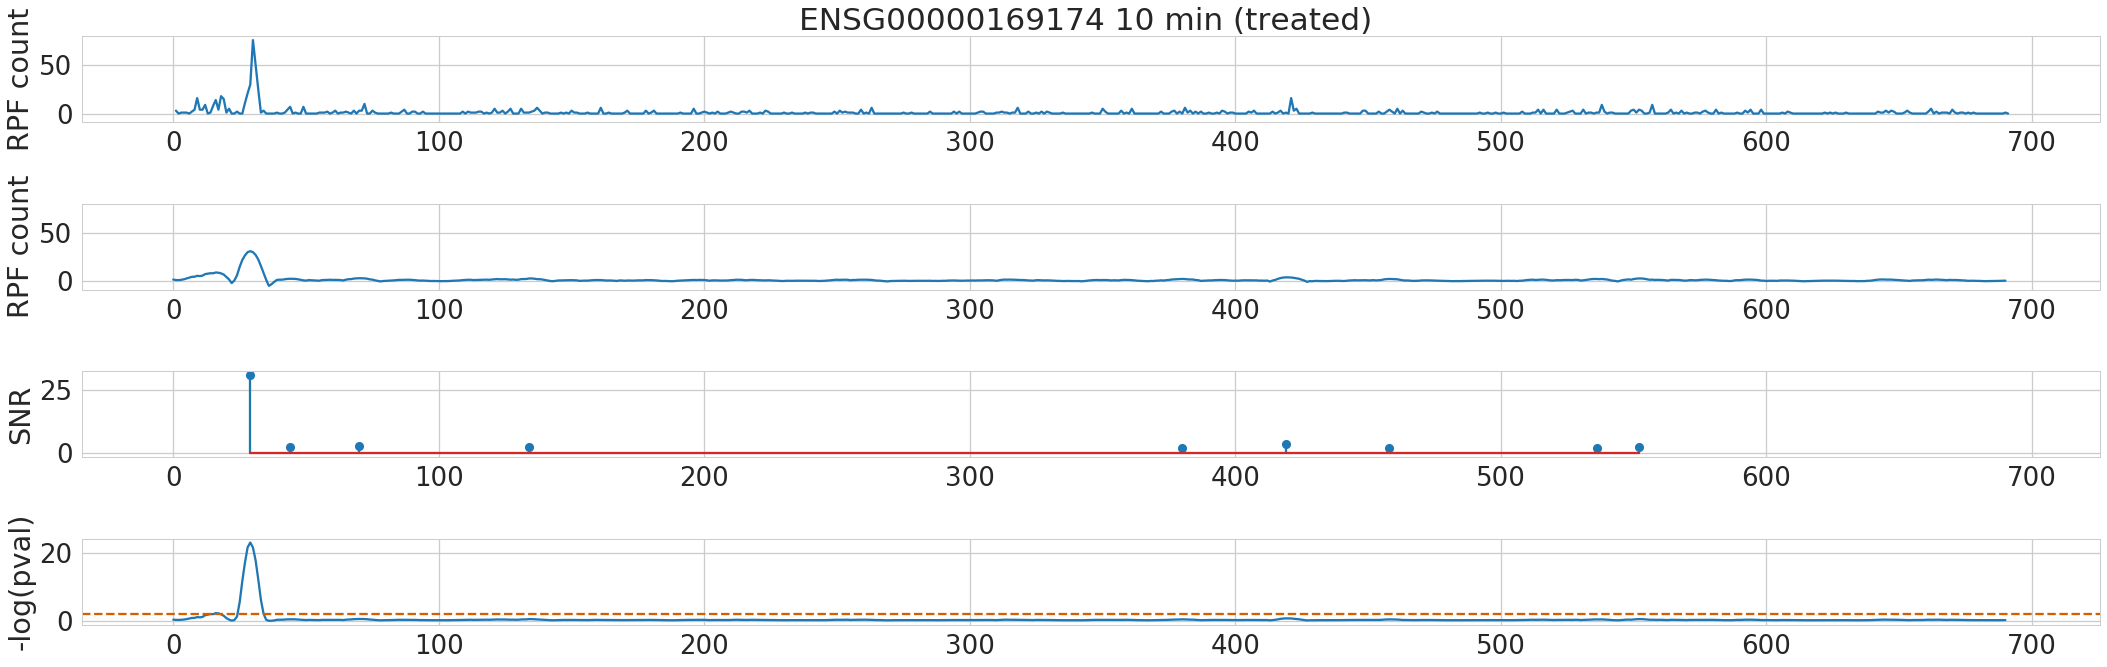

In [361]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(mu15_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (treated) ')
ax1.set_ylabel('RPF count')

filtered = savgol_filter(data, 15, 3)
ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot(filtered)
ax2.set_ylabel('RPF count')

ax3 = plt.subplot(413, sharex=ax1)
peaks_x, peaks_height = calculate_peaks(filtered, order=9, snr=3)
ax3.set_ylabel('SNR')
ax3.stem(peaks_x, peaks_height)

ax4 = plt.subplot(414, sharex=ax1)
pvalues = -np.log10(gaussian_pvalue(filtered))
ax4.plot(pvalues)
ax4.set_ylabel('-log(pval)')
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_10min_sum_gene_profile_zscore_golay.png')

SRX2536409
SRX2536410
SRX2536411


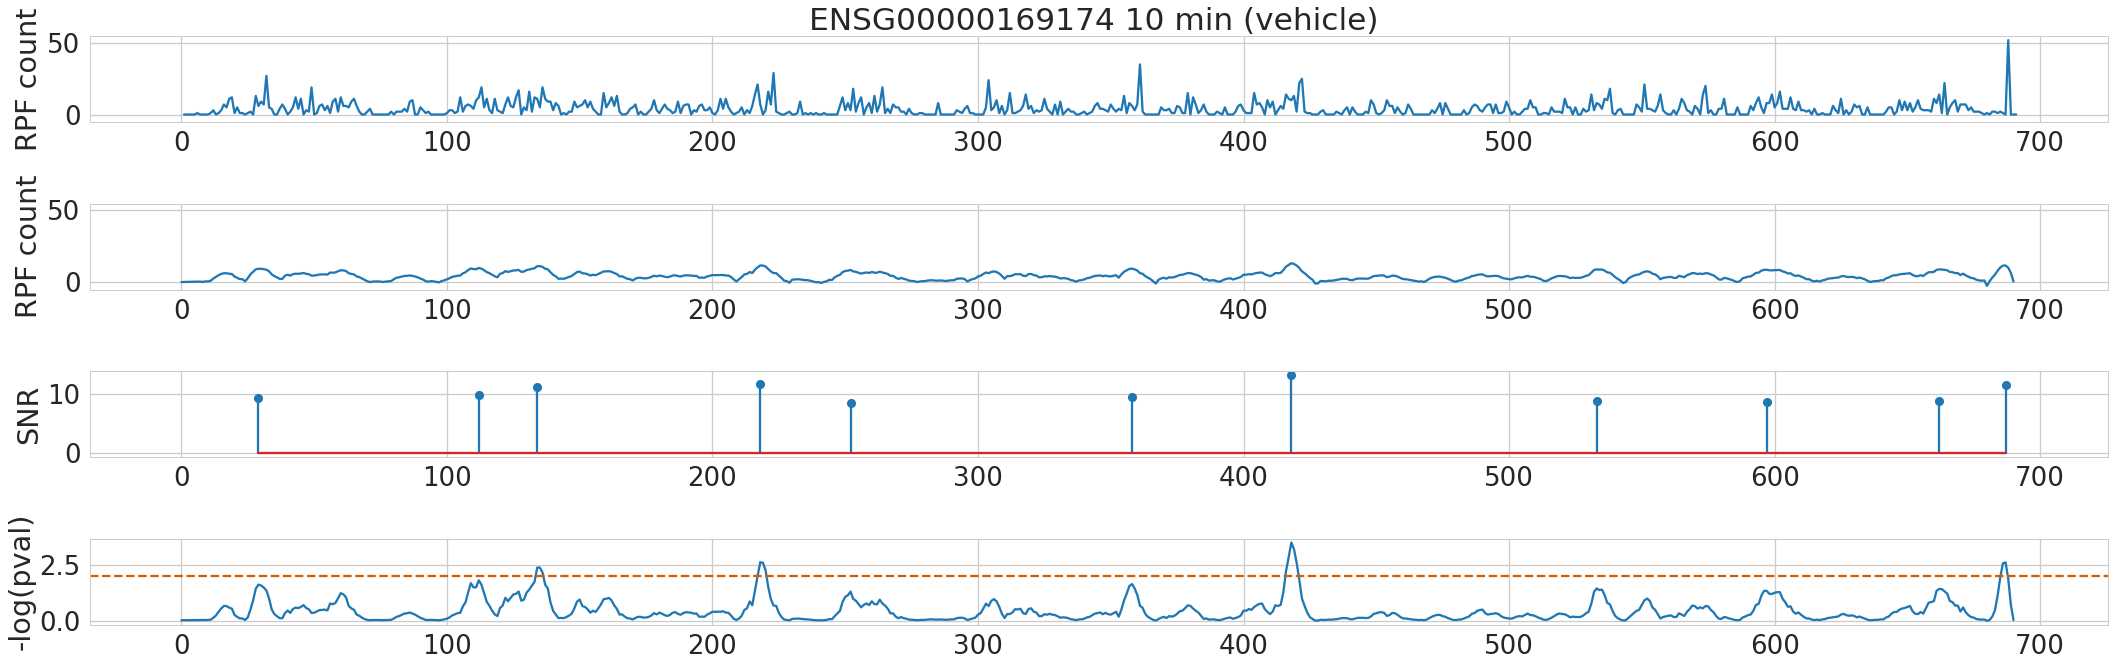

In [360]:
gene_name = 'ENSG00000169174'
vehicle_10min = samples_srx['vehicle']['10min_1']
vehicle_10min_sum = sum_profiles(vehicle_10min, gene_name)


sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = collpase_gene_coverage_to_codon(vehicle_10min_sum)

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (vehicle) ')
ax1.set_ylabel('RPF count')

filtered = savgol_filter(data, 15, 3)
ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot(filtered)
ax2.set_ylabel('RPF count')

ax3 = plt.subplot(413, sharex=ax1)
peaks_x, peaks_height = calculate_peaks(filtered, order=9, snr=3)
ax3.set_ylabel('SNR')
ax3.stem(peaks_x, peaks_height)

ax4 = plt.subplot(414, sharex=ax1)
pvalues = -np.log10(gaussian_pvalue(filtered))
ax4.plot(pvalues)
ax4.set_ylabel('-log(pval)')
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_vehicle_10min_sum_gene_profile_zscore_golay.png')

SRX2536409
SRX2536410
SRX2536411


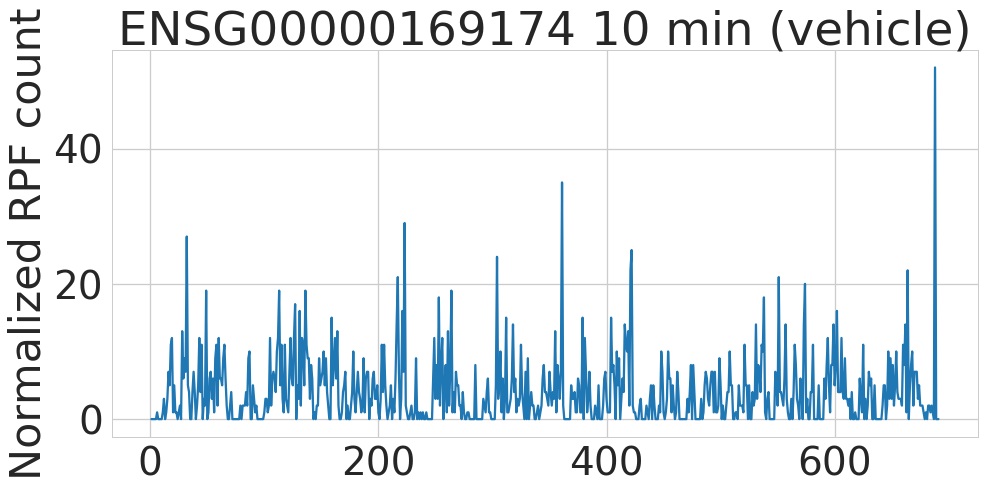

In [350]:
gene_name = 'ENSG00000169174'
vehicle_10min = samples_srx['vehicle']['10min_1']
vehicle_10min_sum = sum_profiles(vehicle_10min, gene_name)

sns.set_context('talk', font_scale=3)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(collpase_gene_coverage_to_codon(vehicle_10min_sum))
ax.set_title(gene_name+' 10 min (vehicle)')
ax.set_ylabel('Normalized RPF count')
fig.tight_layout()
fig.savefig('plots_08April_2018/pcsk9_vehicle_10min_avg_gene_profile.png', dpi=200)

# Will there always be a peak?

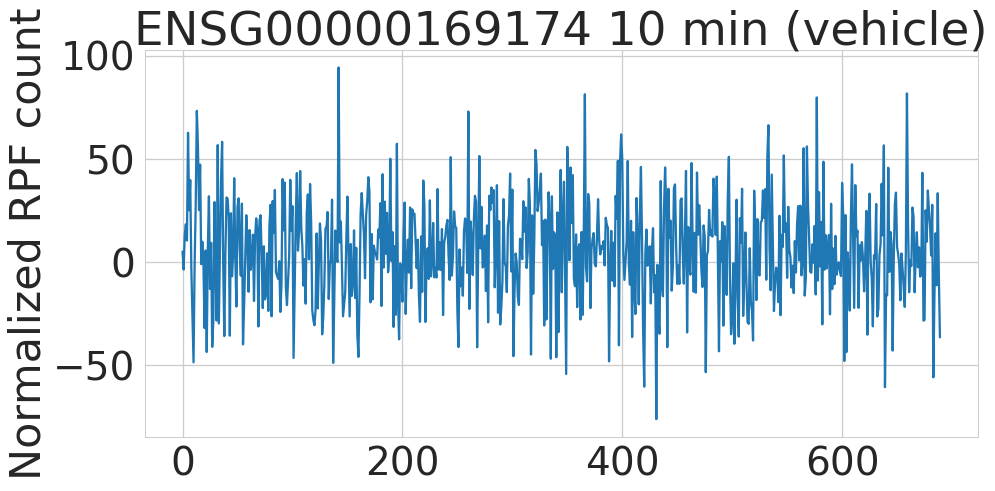

In [375]:
mu = 5
sigma = 25
s = np.random.normal(mu, sigma, 690)
sns.set_context('talk', font_scale=3)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(s)
ax.set_title(gene_name+' 10 min (vehicle)')
ax.set_ylabel('Normalized RPF count')
fig.tight_layout()

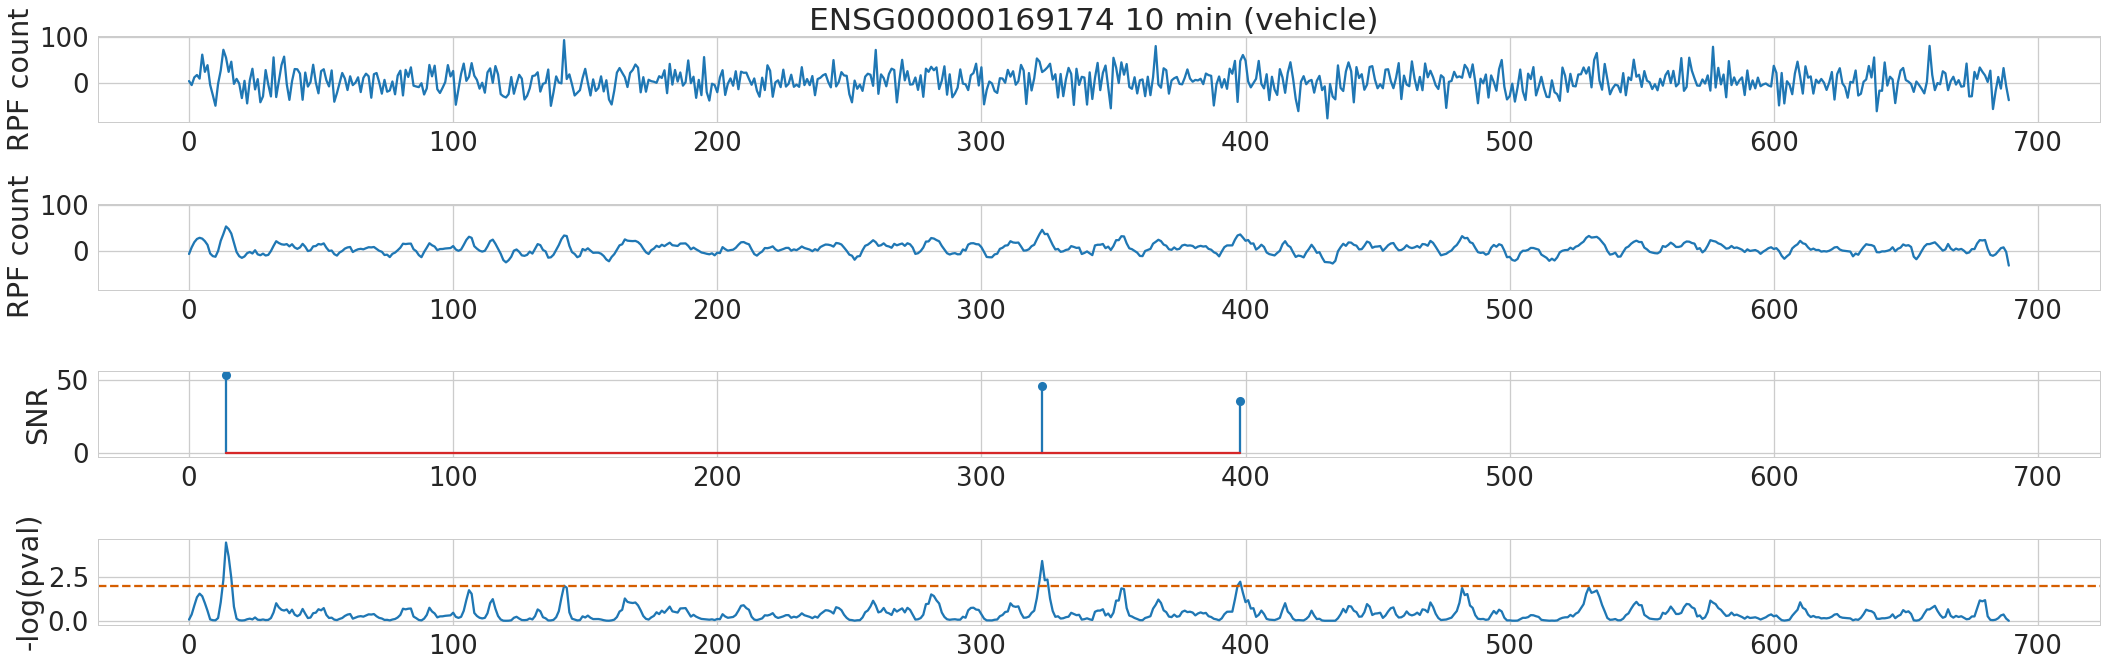

In [377]:
sns.set_context('talk', font_scale=2)
fig  = plt.figure(figsize=(30, 10))
data = s

ax1 = plt.subplot(411)
ax1.plot(data)
ax1.set_title(gene_name+' 10 min (vehicle) ')
ax1.set_ylabel('RPF count')

filtered = savgol_filter(data, 15, 4)
ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
ax2.plot(filtered)
ax2.set_ylabel('RPF count')

ax3 = plt.subplot(413, sharex=ax1)
peaks_x, peaks_height = calculate_peaks(filtered, order=9, snr=3)
ax3.set_ylabel('SNR')
ax3.stem(peaks_x, peaks_height)

ax4 = plt.subplot(414, sharex=ax1)
pvalues = -np.log10(gaussian_pvalue(filtered))
ax4.plot(pvalues)
ax4.set_ylabel('-log(pval)')
ax4.axhline(y=2, color="#D55E00", linestyle='dashed')
fig.tight_layout()

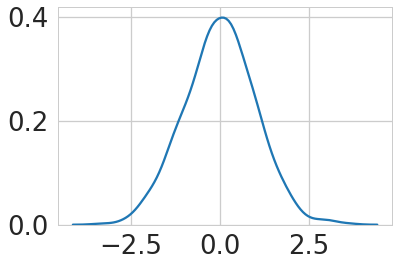

In [379]:
sns.kdeplot(Z_score(s))

# Fit NB

In [392]:
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.tools.tools import add_constant
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
data = s
def fit_nb(data, method='bfgs'):
    res = NegativeBinomial(data, np.ones_like(data)).fit(                                                              
        disp=0, method=method)                               
    l = res.predict()
    print (res.summary())
    print (res.variance())
    return res.params

from scipy.stats import nbinom


def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p


def pmf(counts, mu, theta):
    """
    >>> import numpy as np
    >>> from scipy.stats import poisson
    >>> np.isclose(pmf(10, 10, 10000), poisson.pmf(10, 10), atol=1e-3)
    True
    """
    return nbinom.pmf(counts, *convert_params(mu, theta))


def logpmf(counts, mu, theta):
    return nbinom.logpmf(counts, *convert_params(mu, theta))


def cdf(counts, mu, theta):
    return nbinom.cdf(counts, *convert_params(mu, theta))


def sf(counts, mu, theta):
    return nbinom.sf(counts, *convert_params(mu, theta))

data = collpase_gene_coverage_to_codon(mu15_10min_sum)

fit_nb(data)

                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  691
Model:               NegativeBinomial   Df Residuals:                      690
Method:                           MLE   Df Model:                            0
Date:                Fri, 13 Apr 2018   Pseudo R-squ.:                   0.000
Time:                        14:05:46   Log-Likelihood:                -960.54
converged:                       True   LL-Null:                       -960.54
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2071      0.080      2.578      0.010       0.050       0.365
alpha          3.6475      0.329     11.073      0.000       3.002       4.293


AttributeError: 'NegativeBinomialResults' object has no attribute 'variance'

In [ ]:
def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

data = get_nb_vals(3, 1, 1000)
fit_nb(data)

In [388]:
np.exp(1.08)

2.9446795510655241

In [389]:
# σ2 = μ + αμ2


2.3163669767810915

In [391]:
np.exp(0.84)#*2.94**2

2.3163669767810915

In [394]:
res = NegativeBinomial(data, np.ones_like(data)).fit(                                                              
    disp=0, method='bfgs')                               
l = res.predict()
print (res.summary())
print (res.variance())


                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  691
Model:               NegativeBinomial   Df Residuals:                      690
Method:                           MLE   Df Model:                            0
Date:                Fri, 13 Apr 2018   Pseudo R-squ.:                   0.000
Time:                        14:06:16   Log-Likelihood:                -960.54
converged:                       True   LL-Null:                       -960.54
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2071      0.080      2.578      0.010       0.050       0.365
alpha          3.6475      0.329     11.073      0.000       3.002       4.293


AttributeError: 'NegativeBinomialResults' object has no attribute 'variance'

In [396]:
mu = np.exp(3.6475)
alpha = np.exp(0.2071)
sigma2 
sigma2 = np.exp(0.2071)
mu2 = mu**2

In [397]:
p = (sigma2 - mu)/sigma2
r = mu2/(sigma2-mu)

In [400]:
data = np.random.negative_binomial(r, p, 100000)
plt.plot(data)

ValueError: n <= 0

In [401]:
p

-30.199435446866133